In [320]:
import pandas as pd
from pandas import Series, DataFrame
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
%matplotlib inline

#Machine Learning imports 
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn import svm
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV, LassoCV, Lasso
from sklearn.cluster import KMeans

from sklearn.cross_validation import train_test_split
from sklearn import metrics

from sklearn.cross_validation import cross_val_score
from sklearn.feature_selection import RFE

from sklearn import model_selection
from sklearn.model_selection import GridSearchCV

from sklearn.preprocessing import PolynomialFeatures
from sklearn import preprocessing
from sklearn.decomposition import PCA
from scipy.stats import skew

In [321]:
train = pd.read_csv("ad_org_train.csv")
test = pd.read_csv("ad_org_test.csv")
train.head()

,vidid,adview,views,likes,dislikes,comment,published,duration,category
0,VID_18655,40,1031602,8523,363,1095,2016-09-14,PT7M37S,F
1,VID_14135,2,1707,56,2,6,2016-10-01,PT9M30S,D
2,VID_2187,1,2023,25,0,2,2016-07-02,PT2M16S,C
3,VID_23096,6,620860,777,161,153,2016-07-27,PT4M22S,H
4,VID_10175,1,666,1,0,0,2016-06-29,PT31S,D


In [322]:
columns = ['views', 'likes', 'dislikes', 'comment']
for column in columns:
        train[column] = train[column].apply(pd.to_numeric, errors = 'coerce')
        test[column] = test[column].apply(pd.to_numeric, errors = 'coerce')        
        print (column, train[column].isnull().sum())
        print (column, test[column].isnull().sum())

views 2
views 1
likes 155
likes 88
dislikes 155
dislikes 88
comment 233
comment 151


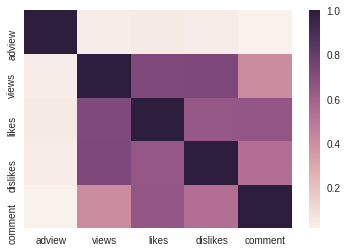

In [323]:
sns.heatmap(train.corr())

In [324]:
train.dropna(inplace=True)
test.dropna(inplace=True)

In [325]:
def time_transform(data):
    duration = data['duration']
    h_pos = 0
    m_pos = 0
    s_pos = len(duration) - 1
    time = 0
    #duration = list(duration)
    if 'H' in duration:
        for i in range(2,len(duration)):
            if duration[i] == 'H':
                h_pos = i
                break
        time = int(duration[2:h_pos]) * 3600 

    if 'M' in duration:
        for i in range(2,len(duration)):
            if duration[i] == 'M':
                m_pos = i
                break
        if 'H' in duration:
            time = time + int(duration[h_pos+1:m_pos]) * 60
        else:
            time = int(duration[2:m_pos]) * 60
        
        if 'S' in duration:
            time = time + int(duration[m_pos+1:s_pos])
        
    else:
        if 'H' not in duration:
            time = time + int(duration[2:s_pos])
        else:
            time = time + int(duration[h_pos+1:s_pos])
    #print (duration, m_pos)
    #time = str(time)
    #print (time)
    data['duration'] = time
    data.head()
    return data

train = train.apply(time_transform, axis=1)
test = test.apply(time_transform, axis=1)

In [326]:
dummies = pd.get_dummies(train.category)
train = train.join(dummies)
test = test.join(dummies)

In [327]:
train.drop(['category'], axis=1,inplace=True)
test.drop(['category'],axis=1, inplace=True)
train.head()

,vidid,adview,views,likes,dislikes,comment,published,duration,A,B,C,D,E,F,G,H
0,VID_18655,40,1031602.0,8523.0,363.0,1095.0,2016-09-14,457,0,0,0,0,0,1,0,0
1,VID_14135,2,1707.0,56.0,2.0,6.0,2016-10-01,570,0,0,0,1,0,0,0,0
2,VID_2187,1,2023.0,25.0,0.0,2.0,2016-07-02,136,0,0,1,0,0,0,0,0
3,VID_23096,6,620860.0,777.0,161.0,153.0,2016-07-27,262,0,0,0,0,0,0,0,1
4,VID_10175,1,666.0,1.0,0.0,0.0,2016-06-29,31,0,0,0,1,0,0,0,0


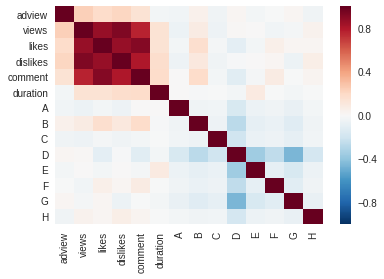

In [328]:
sns.heatmap(train.corr(method='spearman'))

In [329]:
train.corr(method='spearman')

,adview,views,likes,dislikes,comment,duration,A,B,C,D,E,F,G,H
adview,1.000000,0.237642,0.185938,0.214008,0.144622,-0.030875,-0.036865,0.047345,-0.042085,0.018129,-0.023920,-0.000059,0.019098,-0.040601
views,0.237642,1.000000,0.872814,0.930303,0.769998,0.142677,-0.060725,0.082058,-0.048486,0.008746,0.006108,-0.035694,-0.019411,0.046149
likes,0.185938,0.872814,1.000000,0.873085,0.916827,0.142274,-0.029646,0.165609,-0.022554,-0.096843,-0.029013,0.058859,0.020588,0.020707
dislikes,0.214008,0.930303,0.873085,1.000000,0.811613,0.176438,-0.052674,0.103889,-0.042374,-0.010300,0.001293,0.022446,-0.055082,0.062508
comment,0.144622,0.769998,0.916827,0.811613,1.000000,0.183926,0.001486,0.182019,-0.025496,-0.116202,-0.017541,0.084194,-0.005386,0.029607
duration,-0.030875,0.142677,0.142274,0.176438,0.183926,1.000000,0.005113,-0.013426,-0.001295,-0.028253,0.090534,-0.004771,-0.026744,-0.000883
A,-0.036865,-0.060725,-0.029646,-0.052674,0.001486,0.005113,1.000000,-0.042183,-0.031464,-0.159742,-0.055412,-0.040023,-0.071395,-0.027249
B,0.047345,0.082058,0.165609,0.103889,0.182019,-0.013426,-0.042183,1.000000,-0.052938,-0.268768,-0.093232,-0.067339,-0.120122,-0.045846
C,-0.042085,-0.048486,-0.022554,-0.042374,-0.025496,-0.001295,-0.031464,-0.052938,1.000000,-0.200469,-0.069540,-0.050227,-0.089597,-0.034196
D,0.018129,0.008746,-0.096843,-0.010300,-0.116202,-0.028253,-0.159742,-0.268768,-0.200469,1.000000,-0.353054,-0.255003,-0.454885,-0.173612


lbl = preprocessing.LabelEncoder()
lbl.fit(list(train['category'].values))
train['category'] = lbl.transform(list(train['category'].values))
test['category'] = lbl.transform(list(test['category'].values))

In [330]:
train['published'] = pd.to_datetime(train['published'])
test['published'] = pd.to_datetime(test['published'])

train['dayofweek'] = train.published.dt.dayofweek
test['dayofweek'] = test.published.dt.dayofweek
#quarter didn't work
#weekofyear didn't work

train['year'] = train.published.dt.year
test['year'] = test.published.dt.year

train['month'] = train.published.dt.month
test['month'] = test.published.dt.month

train.drop(['published'], axis=1, inplace=True)
test.drop(['published'], axis=1, inplace=True)

In [331]:
test.drop(['vidid'], axis=1, inplace=True)
train.drop(['vidid'], axis=1, inplace=True)

In [332]:
train.head()

,adview,views,likes,dislikes,comment,duration,A,B,C,D,E,F,G,H,dayofweek,year,month
0,40,1031602.0,8523.0,363.0,1095.0,457,0,0,0,0,0,1,0,0,2,2016,9
1,2,1707.0,56.0,2.0,6.0,570,0,0,0,1,0,0,0,0,5,2016,10
2,1,2023.0,25.0,0.0,2.0,136,0,0,1,0,0,0,0,0,5,2016,7
3,6,620860.0,777.0,161.0,153.0,262,0,0,0,0,0,0,0,1,2,2016,7
4,1,666.0,1.0,0.0,0.0,31,0,0,0,1,0,0,0,0,2,2016,6


columns = ['adview', 'views', 'likes', 'dislikes', 'comment']
for x in columns:
    temp = train[x]
    mean = temp.mean()
    std = temp.std()
    final_list = [z for z in temp if (z > mean - 4 * std)]
    final_list = [z for z in final_list if (z < mean + 4*std)]
    temp = Series(final_list)
    train[x] = temp
    print (x, train[x].isnull().sum())

poly = PolynomialFeatures(degree=2,interaction_only=True)

columns = ['views', 'likes', 'dislikes', 'comment', 'duration']

z_train = poly.fit_transform(train[columns])

z_train = pd.DataFrame(z_train)

z_train.head()

In [333]:
columns = ['adview','views', 'likes', 'dislikes', 'comment', 'duration']

std_scaler = preprocessing.StandardScaler()
std_scaler.fit(train[columns])
train[columns] = std_scaler.transform(train[columns])

In [334]:
for x in columns:
    train[x] = np.log1p(train[x])

In [335]:
train.head()

,adview,views,likes,dislikes,comment,duration,A,B,C,D,E,F,G,H,dayofweek,year,month
0,3.713572,13.846624,9.050641,5.897154,6.999422,6.126869,0,0,0,0,0,1,0,0,2,2016,9
1,1.098612,7.443078,4.043051,1.098612,1.945910,6.347389,0,0,0,1,0,0,0,0,5,2016,10
2,0.693147,7.612831,3.258097,0.000000,1.098612,4.919981,0,0,1,0,0,0,0,0,5,2016,7
3,1.945910,13.338863,6.656727,5.087596,5.036953,5.572154,0,0,0,0,0,0,0,1,2,2016,7
4,0.693147,6.502790,0.693147,0.000000,0.000000,3.465736,0,0,0,1,0,0,0,0,2,2016,6


In [336]:
train['v_l_r'] = train['views'] / train['likes']
train['v_dur_r'] = train['views'] / train['duration']
train['l_dis_r'] = train['likes'] / train['dislikes']
train['l_dur_r'] = train['likes'] / train['duration']
train['l_dur_p'] = train['likes'] * train['duration']
train['v_dur_p'] = train['views'] * train['duration']

In [337]:
train.head()

,adview,views,likes,dislikes,comment,duration,A,B,C,D,...,H,dayofweek,year,month,v_l_r,v_dur_r,l_dis_r,l_dur_r,l_dur_p,v_dur_p
0,3.713572,13.846624,9.050641,5.897154,6.999422,6.126869,0,0,0,0,...,0,2,2016,9,1.529905,2.259984,1.534747,1.477205,55.452093,84.836457
1,1.098612,7.443078,4.043051,1.098612,1.945910,6.347389,0,0,0,1,...,0,5,2016,10,1.840956,1.172620,3.680144,0.636963,25.662820,47.244115
2,0.693147,7.612831,3.258097,0.000000,1.098612,4.919981,0,0,1,0,...,0,5,2016,7,2.336589,1.547329,inf,0.662217,16.029773,37.454983
3,1.945910,13.338863,6.656727,5.087596,5.036953,5.572154,0,0,0,0,...,1,2,2016,7,2.003817,2.393843,1.308423,1.194642,37.092306,74.326196
4,0.693147,6.502790,0.693147,0.000000,0.000000,3.465736,0,0,0,1,...,0,2,2016,6,9.381543,1.876309,inf,0.200000,2.402265,22.536953


In [338]:
train = train.replace([np.inf, -np.inf], np.NaN)

In [339]:
train.v_l_r.fillna(train.v_l_r.mean(), inplace=True)
train.v_dur_r.fillna(train.v_dur_r.mean(), inplace=True)
train.l_dis_r.fillna(train.l_dis_r.mean(), inplace=True)
train.l_dur_r.fillna(train.l_dur_r.mean(), inplace=True)

In [340]:
train.shape

(14637, 23)

In [341]:
train.head()

,adview,views,likes,dislikes,comment,duration,A,B,C,D,...,H,dayofweek,year,month,v_l_r,v_dur_r,l_dis_r,l_dur_r,l_dur_p,v_dur_p
0,3.713572,13.846624,9.050641,5.897154,6.999422,6.126869,0,0,0,0,...,0,2,2016,9,1.529905,2.259984,1.534747,1.477205,55.452093,84.836457
1,1.098612,7.443078,4.043051,1.098612,1.945910,6.347389,0,0,0,1,...,0,5,2016,10,1.840956,1.172620,3.680144,0.636963,25.662820,47.244115
2,0.693147,7.612831,3.258097,0.000000,1.098612,4.919981,0,0,1,0,...,0,5,2016,7,2.336589,1.547329,1.865335,0.662217,16.029773,37.454983
3,1.945910,13.338863,6.656727,5.087596,5.036953,5.572154,0,0,0,0,...,1,2,2016,7,2.003817,2.393843,1.308423,1.194642,37.092306,74.326196
4,0.693147,6.502790,0.693147,0.000000,0.000000,3.465736,0,0,0,1,...,0,2,2016,6,9.381543,1.876309,1.865335,0.200000,2.402265,22.536953


In [342]:
train.describe()

,adview,views,likes,dislikes,comment,duration,A,B,C,D,...,H,dayofweek,year,month,v_l_r,v_dur_r,l_dis_r,l_dur_r,l_dur_p,v_dur_p
count,14637.000000,14637.000000,14637.000000,14637.000000,14637.000000,14637.000000,14637.000000,14637.000000,14637.000000,14637.000000,...,14637.000000,14637.000000,14637.000000,14637.000000,14637.000000,14637.000000,14637.000000,14637.000000,14637.000000,14637.000000
mean,1.775890,11.663483,5.941545,3.622963,3.814112,5.972230,0.024459,0.066270,0.037986,0.504407,...,0.028763,2.777960,2014.437521,6.643848,2.247721,2.026230,1.865335,1.020281,35.987846,70.255768
std,1.907178,2.253479,2.270957,2.056127,2.244179,1.289636,0.154473,0.248763,0.191169,0.499998,...,0.167145,1.905286,1.770521,3.291857,1.136952,0.538253,0.865372,0.428190,15.732637,21.451606
min,0.693147,3.912023,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,2005.000000,1.000000,1.210872,0.605102,0.000000,0.000000,0.000000,0.000000
25%,0.693147,10.358314,4.488636,2.079442,2.079442,5.236442,0.000000,0.000000,0.000000,0.000000,...,0.000000,1.000000,2013.000000,4.000000,1.707261,1.631355,1.379890,0.722454,25.518490,56.831181
50%,1.098612,11.974576,6.111467,3.663562,3.850148,5.786897,0.000000,0.000000,0.000000,1.000000,...,0.000000,3.000000,2015.000000,7.000000,1.957872,1.985613,1.660034,1.007317,36.648583,70.369287
75%,1.945910,13.276995,7.530480,5.123964,5.416100,6.584791,0.000000,0.000000,0.000000,1.000000,...,0.000000,4.000000,2016.000000,9.000000,2.336782,2.357956,1.985252,1.307721,46.817082,82.941493
max,15.507388,18.743111,12.556113,10.808717,11.225857,10.652968,1.000000,1.000000,1.000000,1.000000,...,1.000000,6.000000,2017.000000,12.000000,17.226158,7.267596,10.009829,4.029542,97.223746,154.027918


In [343]:
train['views_square'] = train.views.pow(2)

In [344]:
train['views_sqrt'] = train.views.pow(0.5)

In [345]:
train['views_permonth'] = train['views'] * train['month']

In [346]:
train.head()

,adview,views,likes,dislikes,comment,duration,A,B,C,D,...,month,v_l_r,v_dur_r,l_dis_r,l_dur_r,l_dur_p,v_dur_p,views_square,views_sqrt,views_permonth
0,3.713572,13.846624,9.050641,5.897154,6.999422,6.126869,0,0,0,0,...,9,1.529905,2.259984,1.534747,1.477205,55.452093,84.836457,191.729009,3.721105,124.619620
1,1.098612,7.443078,4.043051,1.098612,1.945910,6.347389,0,0,0,1,...,10,1.840956,1.172620,3.680144,0.636963,25.662820,47.244115,55.399416,2.728201,74.430784
2,0.693147,7.612831,3.258097,0.000000,1.098612,4.919981,0,0,1,0,...,7,2.336589,1.547329,1.865335,0.662217,16.029773,37.454983,57.955196,2.759136,53.289817
3,1.945910,13.338863,6.656727,5.087596,5.036953,5.572154,0,0,0,0,...,7,2.003817,2.393843,1.308423,1.194642,37.092306,74.326196,177.925253,3.652241,93.372038
4,0.693147,6.502790,0.693147,0.000000,0.000000,3.465736,0,0,0,1,...,6,9.381543,1.876309,1.865335,0.200000,2.402265,22.536953,42.286278,2.550057,39.016740


train.loc[train.adview > 12] = train.adview.mean()

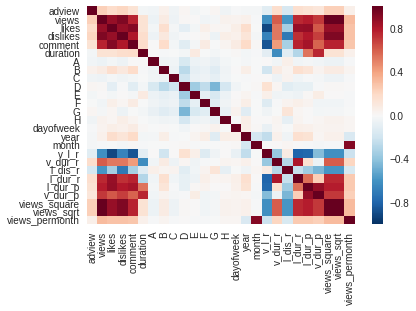

In [347]:
sns.heatmap(train.corr(method='spearman'))

In [348]:
y_train = train['adview']
train = train.drop(['adview'], axis = 1)

Random Forests
MAE : 1.028175
RMSE : 1.676859
Auc: 44.261103
R2: 0.274811


model_score 0.894651868502


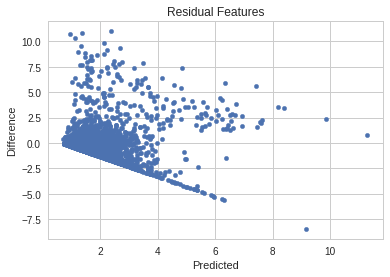

In [349]:
def display_metrics(y_test, y_pred):
    print ("MAE : %f" % metrics.mean_absolute_error(y_test, y_pred))
    print ("RMSE : %f" % np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
    #print ("NRMSE : %f" % np.mean(np.abs((y_test - y_pred)/y_test)) * 100)
    print ("Auc: %f" % metrics.auc(y_test, y_pred,reorder=True))
    print ("R2: %f" % metrics.r2_score(y_test, y_pred))
    #print ("fbeta: %f" % metrics.fbeta_score(y_test, y_pred, beta=2))
    print ("\n")
           
def model_train(model,X,y):
    # Split test, train
    X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2, random_state = 1)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    display_metrics(y_test, y_pred)
    
    print ('model_score', model.score(X_train, y_train))
    
    plt.figure(figsize= (50,10))
    preds = pd.DataFrame({"Predicted":model.predict(X_test), "true":y_test})
    preds["Difference"] = preds["true"] - preds["Predicted"]
    preds.plot(x = "Predicted", y = "Difference",kind = "scatter", title = "Residual Features")
    plt.show()
    
def training(X,y):   
    
    
    #Random Forests
    rand_clf = RandomForestRegressor(n_jobs=-1, bootstrap=True, n_estimators = 300)
    print ("Random Forests")
    model_train(rand_clf, X, y)

    #Ridge Regression
#    ridge_clf = Ridge(alpha=0.001, normalize=True)
#    print ("Ridge Regression")
#    model_train(ridge_clf, X, y)
    
    #Lasso Regression
#    lasso_clf = Lasso(alpha=0.001, normalize=True)
#    print ("Lasso Regression")
#    model_train(lasso_clf, X, y)
    
    #MLP Regression
#    mlp_clf = MLPRegressor(solver = 'lbfgs', alpha = 0.01, hidden_layer_sizes=(10,10), random_state= 1)
#    print ("MLP (NN)")
#    model_train(mlp_clf, X, y)
    
    
    return rand_clf

rand_reg = training(train, y_train)


rf = RandomForestRegressor(n_jobs=-1, bootstrap=True, n_estimators=300)
scores = []
for i in range(train.shape[1]):
    score = cross_val_score(rf, train.iloc[:, i:i+1], y_train, scoring="r2",
                              cv=3)
    scores.append((round(np.mean(score), 3)))
print (scores)

In [309]:
X_train, X_test, y_train, y_test = train_test_split(train,y_train,test_size=0.2, random_state = 1)

In [350]:
random_forest = RandomForestRegressor(n_jobs=-1, bootstrap=True, n_estimators=300)

In [351]:
rfe = RFE(random_forest, n_features_to_select=1)

In [352]:
rfe.fit(train, y_train)

RFE(estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=300, n_jobs=-1, oob_score=False, random_state=None,
           verbose=0, warm_start=False),
  n_features_to_select=1, step=1, verbose=0)

In [354]:
print (sorted(zip(map(lambda x: round(x, 4), rfe.ranking_), train.columns)))

[(1, 'views_sqrt'), (2, 'v_l_r'), (3, 'v_dur_r'), (4, 'views_permonth'), (5, 'l_dis_r'), (6, 'v_dur_p'), (7, 'l_dur_r'), (8, 'comment'), (9, 'views'), (10, 'year'), (11, 'duration'), (12, 'dislikes'), (13, 'l_dur_p'), (14, 'views_square'), (15, 'likes'), (16, 'dayofweek'), (17, 'month'), (18, 'G'), (19, 'F'), (20, 'D'), (21, 'E'), (22, 'B'), (23, 'A'), (24, 'C'), (25, 'H')]


In [311]:
random_forest.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=300, n_jobs=-1, oob_score=False, random_state=None,
           verbose=0, warm_start=False)

In [312]:
y_pred = random_forest.predict(X_test)

In [313]:
random_forest.score(X_train, y_train)

0.89491863926246884

In [314]:
random_forest.score(X_test,y_test)

0.27430238696143017

In [315]:
# get Correlation Coefficient for each feature using Logistic Regression
coeff_df = DataFrame(X_train.columns)
coeff_df.columns = ['Features']
coeff_df["Coefficient Estimate"] = pd.Series(random_forest.feature_importances_)

# preview
coeff_df

,Features,Coefficient Estimate
0,views,0.044491
1,likes,0.039909
2,dislikes,0.046743
3,comment,0.054913
4,duration,0.048943
5,A,0.006907
6,B,0.006136
7,C,0.002338
8,D,0.010006
9,E,0.006975


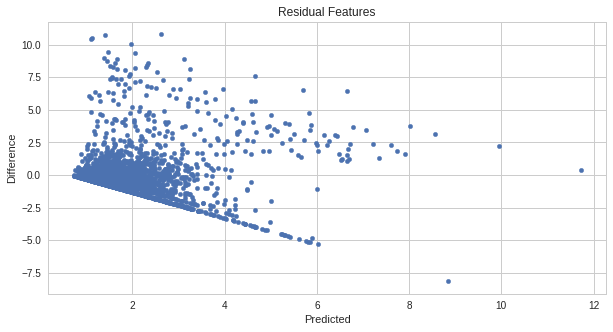

In [318]:
#Remaining Feature Set
plt.figure(figsize= (50,10))
preds = pd.DataFrame({"Predicted":random_forest.predict(X_test), "true":y_test})
preds["Difference"] = preds["true"] - preds["Predicted"]
preds.plot(x = "Predicted", y = "Difference",kind = "scatter", title = "Residual Features",figsize=(10,5))

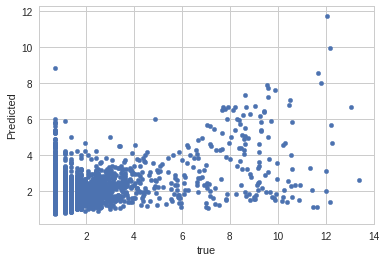

In [319]:
preds.plot(kind='scatter', x='true', y='Predicted')

In [117]:
kmeans = KMeans(n_clusters=7,n_jobs=-1).fit(train)

In [118]:
y_pred2 = kmeans.fit_predict(train)

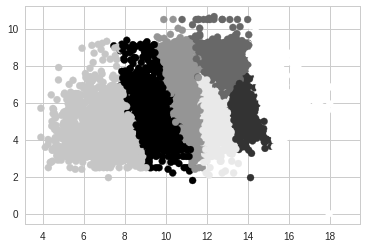

In [119]:
plt.scatter(train['views'], train['duration'], c=y_pred2)